In this lecture, we do a deep dive into data aggregation and pivot table. A **pivot table** is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data. The pivot table takes simple column-wise data as inputs, and groups the entries into a two-dimensional table that provides a multi-dimensional summarization of the data. You can think of pivot table as essentially a multi-dimensional version of group-by aggregation. That is, you 'split-apply-combine', but both the 'split' and 'combine' happpen across not a one-dimensional index, but across two-dimensional grid. 

We will use the good old titanic dataset as our motivating example. We first review group-by logic and then discuss advanced usage of pivot table.

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [47]:
titanic=sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
print(titanic.shape)
print(titanic.info())

(891, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       889 non-null object
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.6+ KB
None


Now let's do a quick frequency check on how many people survived the incidence:

In [4]:
titanic['survived'].value_counts()

0    549
1    342
Name: survived, dtype: int64

#### I. Review on Group-By Operations

We first review group-by operations. We will start our discussion on summarizing data. For numpy's 'ndarray' and pandas' 'DataFrame' and 'Series' objects, aggregation can be done easily. Below are some examples:

In [5]:
# 'Series' objects:
rng = np.random.RandomState(455)
ser = pd.Series(rng.rand(5))
print(ser)
print(ser.sum(), '\n')

# 'ndarrays' objects:
array=np.array([[1,2,3],[4,5,6]])
print(array)
print(array.sum()) # default is to compute the mean of the flattened array (default value is None)
print(array.sum(axis=1)) # adding up all rows
print(array.sum(axis=0)) # adding up all columns

0    0.412234
1    0.357104
2    0.328402
3    0.019363
4    0.977466
dtype: float64
2.094567989837687 

[[1 2 3]
 [4 5 6]]
21
[ 6 15]
[5 7 9]


Notice that when it comes to matrices (numpy.ndarray), the methods associated each has its own definition. Usually, the methods all require some types of 'axis' argument to ask the coder on what dimension should the calculation be performed. 

If we are able to do summary information on 'Series' objects, we should be able to do that on a 'DataFrame' objects as well. Here using the titanic example, let's first calculate the mean value of 'age' and 'fare' columns:

In [6]:
print(titanic[['age','fare']].mean())
type(titanic.mean()) # the result is a 'Series' object

age     29.699118
fare    32.204208
dtype: float64


pandas.core.series.Series

Simple aggregations can give us a flavor of the dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called 'group-by' operation. The best way to understand the group-by operation is the following: split, apply, combine. The 'split' step involves breaking up and grouping a 'DataFrame' depending on the value of the specified key. The 'apply' step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups. The 'combine' step merges the results of these operations into an output array.

(-1.5, 5)

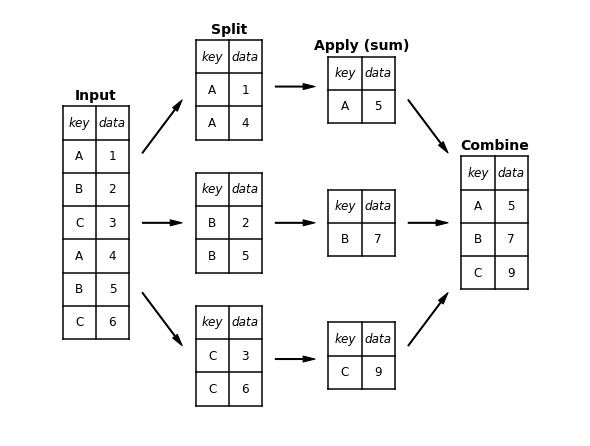

In [7]:
def draw_dataframe(df, loc=None, width=None, ax=None, linestyle=None, textstyle=None):
    loc = loc or [0, 0]
    width = width or 1
    x, y = loc

    if ax is None:
        ax = plt.gca()

    ncols = len(df.columns) + 1
    nrows = len(df.index) + 1

    dx = dy = width / ncols

    if linestyle is None:
        linestyle = {'color':'black'}
    if textstyle is None:
        textstyle = {'size': 12}

    textstyle.update({'ha':'center', 'va':'center'})

    # draw vertical lines
    for i in range(ncols + 1):
        plt.plot(2 * [x + i * dx], [y, y + dy * nrows], **linestyle)

    # draw horizontal lines
    for i in range(nrows + 1):
        plt.plot([x, x + dx * ncols], 2 * [y + i * dy], **linestyle)

    # Create index labels
    for i in range(nrows - 1):
        plt.text(x + 0.5 * dx, y + (i + 0.5) * dy,
                 str(df.index[::-1][i]), **textstyle)

    # Create column labels
    for i in range(ncols - 1):
        plt.text(x + (i + 1.5) * dx, y + (nrows - 0.5) * dy,
                 str(df.columns[i]), style='italic', **textstyle)
        
    # Add index label
    if df.index.name:
        plt.text(x + 0.5 * dx, y + (nrows - 0.5) * dy,
                 str(df.index.name), style='italic', **textstyle)

    # Insert data
    for i in range(nrows - 1):
        for j in range(ncols - 1):
            plt.text(x + (j + 1.5) * dx,
                     y + (i + 0.5) * dy,
                     str(df.values[::-1][i, j]), **textstyle)

#----------------------------------------------------------
# Draw figure

df = pd.DataFrame({'data': [1, 2, 3, 4, 5, 6]},
                   index=['A', 'B', 'C', 'A', 'B', 'C'])
df.index.name = 'key'


fig = plt.figure(figsize=(8, 6), facecolor='white')
ax = plt.axes([0, 0, 1, 1])

ax.axis('off')

draw_dataframe(df, [0, 0])

for y, ind in zip([3, 1, -1], 'ABC'):
    split = df[df.index == ind]
    draw_dataframe(split, [2, y])

    sum = pd.DataFrame(split.sum()).T
    sum.index = [ind]
    sum.index.name = 'key'
    sum.columns = ['data']
    draw_dataframe(sum, [4, y + 0.25])
    
result = df.groupby(df.index).sum()
draw_dataframe(result, [6, 0.75])

style = dict(fontsize=14, ha='center', weight='bold')
plt.text(0.5, 3.6, "Input", **style)
plt.text(2.5, 4.6, "Split", **style)
plt.text(4.5, 4.35, "Apply (sum)", **style)
plt.text(6.5, 2.85, "Combine", **style)

arrowprops = dict(facecolor='black', width=1, headwidth=6)
plt.annotate('', (1.8, 3.6), (1.2, 2.8), arrowprops=arrowprops)
plt.annotate('', (1.8, 1.75), (1.2, 1.75), arrowprops=arrowprops)
plt.annotate('', (1.8, -0.1), (1.2, 0.7), arrowprops=arrowprops)

plt.annotate('', (3.8, 3.8), (3.2, 3.8), arrowprops=arrowprops)
plt.annotate('', (3.8, 1.75), (3.2, 1.75), arrowprops=arrowprops)
plt.annotate('', (3.8, -0.3), (3.2, -0.3), arrowprops=arrowprops)

plt.annotate('', (5.8, 2.8), (5.2, 3.6), arrowprops=arrowprops)
plt.annotate('', (5.8, 1.75), (5.2, 1.75), arrowprops=arrowprops)
plt.annotate('', (5.8, 0.7), (5.2, -0.1), arrowprops=arrowprops)
    
plt.axis('equal')
plt.ylim(-1.5, 5)

The output of the group-by operation is called a 'GroupBy' object. In many ways, you can simply treat it as if it's a collection of 'DataFrame' objects. It's a bit hard to understand the nature of the object at first glance because it’s **lazy** in nature. It doesn’t really do any operations to produce a useful result until you say so. In other words,  it delays virtually every part of the split-apply-combine process until you invoke a method on it.

To actually make the 'GroupBy' start to 'work', we will need to apply methods to it. To start with, the 'GroupBy' object supports column indexing in the same way as the 'DataFrame', and returns a modified 'GroupBy' object. In the example below, we are selecting a particular 'Series' group from the original 'DataFrame' group by reference to its column name. Again, as with the 'GroupBy' object, no computation is done until we call some aggregate on the object:

In [8]:
titanic.groupby(by=['survived']) # no computation is done at this moment since we haven't performed any aggregation on it

In [9]:
mean_age_by_survival=titanic.groupby('survived')['age'].mean()
print(type(mean_age_by_survival))
mean_age_by_survival

<class 'pandas.core.series.Series'>


survived
0    30.626179
1    28.343690
Name: age, dtype: float64

The 'by' argument in the groupby() method specifies the groups for the group-by operation. The 'axis' argument splits along rows (0) or columns (1) (default is of course 0). 

Through some Python class magic, any method not explicitly implemented by the 'GroupBy' object will be passed through and called on the groups, whether they are 'DataFrame' or 'Series' objects. For example, you can use the describe() method of 'DataFrames' to perform a set of aggregations that describe each group in the data:

In [10]:
titanic.groupby('survived')['age'].describe()

,count,mean,std,min,25%,50%,75%,max
survived,,,,,,,,
0,424.0,30.626179,14.172110,1.00,21.0,28.0,39.0,74.0
1,290.0,28.343690,14.950952,0.42,19.0,28.0,36.0,80.0


The 'GroupBy' objects are special objects, so they must have associated methods attached to their class definition. For groupby() method, it has aggregate(), filter(), transform(), and apply() methods that efficiently implement a variety of useful operations before combining the grouped data. To start with, we're now familiar with 'GroupBy' aggregations with sum(), median(), and the like, but the aggregate() method allows for even more flexibility. It can take a string, a function, or a list thereof, and compute all the aggregates at once. Below, we want to know based on the survival conditions, what's the statistics on the age. So we are interested in looking at the age distribution among the survived and the deceased:

In [11]:
dist_age=titanic.groupby(['survived'])['age'].aggregate([min, np.mean, max]) # the result is a 'DataFrame' object
dist_age

,min,mean,max
survived,,,
0,1.00,30.626179,74.0
1,0.42,28.343690,80.0


Another pattern that happened a lot in old versions of the groupby() method is to pass a dictionary mapping column names to operations to be applied on that column. We will omit the detail here.

While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine. For such a transformation, the output is the same shape as the input. A common example is to center the data by subtracting the group-wise mean:

In [12]:
titanic.groupby('survived')['age'].transform(lambda x: x - x.mean())

0     -8.626179
1      9.656310
2     -2.343690
3      6.656310
4      4.373821
         ...   
886   -3.626179
887   -9.343690
888         NaN
889   -2.343690
890    1.373821
Name: age, Length: 891, dtype: float64

Remember the transform() method for 'DataFrame' objects calls a function on self-producing a 'DataFrame' with transformed values and that has the same axis length as self. Here is an example of using the transform() function in a regular setting without aggregation:

In [13]:
pseudo_data = pd.DataFrame({"A":[12, 4, 5, None, 1],  
                   "B":[7, 2, 54, 3, None],  
                   "C":[20, 16, 11, 3, 8],  
                   "D":[14, 3, None, 2, 6]})  
index_ = ['Row_1', 'Row_2', 'Row_3', 'Row_4', 'Row_5'] # creating the index
pseudo_data.index = index_  # setting the index
result = pseudo_data.transform(func = lambda x : x*10)  # multiplying 10 to each column

print('original data:\n', pseudo_data)
print('multiplying 10 to each column:\n', result)

original data:
           A     B   C     D
Row_1  12.0   7.0  20  14.0
Row_2   4.0   2.0  16   3.0
Row_3   5.0  54.0  11   NaN
Row_4   NaN   3.0   3   2.0
Row_5   1.0   NaN   8   6.0
multiplying 10 to each column:
            A      B    C      D
Row_1  120.0   70.0  200  140.0
Row_2   40.0   20.0  160   30.0
Row_3   50.0  540.0  110    NaN
Row_4    NaN   30.0   30   20.0
Row_5   10.0    NaN   80   60.0


Essentially, what the transform() method from above can help us achieve is to get the same number (rows) of the original data without losing record-level information. If you think about the proc sql procedures in SAS, we can sometimes do a group-by operation while still maintaining the rest of the columns and individual record-level details. The transform() method works in a similar way. 

Last but not least, the apply() method lets you apply an arbitrary function to the group results. The function should take a 'DataFrame' object, and return either a Pandas object (e.g., 'DataFrame', 'Series') or a scalar; the combine operation will be tailored to the type of output returned. Here is an example (the function normalizes the first column by the sum of the second):

In [14]:
rng = np.random.RandomState(0)
df2 = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'column1': range(6),
                   'column2': rng.randint(0, 10, 6)},
                   columns = ['key', 'column1', 'column2'])
print(df2)

def norm_by_data2(x):
    # x is a DataFrame of group values
    x['column1'] /= x['column2'].sum()
    return x

df2.groupby('key').apply(norm_by_data2)

  key  column1  column2
0   A        0        5
1   B        1        0
2   C        2        3
3   A        3        3
4   B        4        7
5   C        5        9


,key,column1,column2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3
3,A,0.375000,3
4,B,0.571429,7
5,C,0.416667,9


Essentially, the message here is that you can treat the 'GroupBy' object loosely (almost) as 'DataFrames' so that lots of methods associated with the original 'DataFrame' object can be carried over, or similar methods can be applied at least. The 'GroupBy objects' are 'dormant' 'DataFrame' objects: it will only manifest itself about its 'DataFrame' nature until we reveal it thorough calling a method associated with it. 

#### II. Pivot Tables

Now we move onto pivot tables. Let's start from the most simple example and then compare it with the traditional 'GroupBy' object. Here we group by 'class' and 'gender', select survival, and apply a mean aggregate, then combine the resulting groups and unstack the hierachical index to reveal the hidden multi-dimensionality. The mean function essentially computes the probability of survival on the ship:

In [15]:
titanic.pivot_table(values=['survived'], index='sex', columns='class') # this is a 'DataFrame' and the default function is mean

survived                    
class      First    Second     Third
sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447

In [16]:
titanic.groupby(by=['sex','class'])['survived'].aggregate('mean').unstack() # unstacking the hierarchical index 

class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


If we don't unstack the result, our output looks like the following. This is similar to following SQL command:

    - SELECT MEAN(survived) 
      FROM titanic
      GROUP BY sex, class; 

In [17]:
titanic.groupby(by=['sex','class'])['survived'].aggregate('mean')

sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

Just like the 'GroupBy' objects, groupgins in pivot tables can be specified with multiple levels, and via a number of options. For example, we might be interested in looking at age as a third dimenion, and we will bin the age using the pd.cut() function:

In [24]:
age_bucket=pd.cut(titanic['age'],[0,18,80]) # this generates a 'Series' object
age_bucket.unique()

[(18.0, 80.0], NaN, (0.0, 18.0]]
Categories (2, interval[int64]): [(0, 18] < (18, 80]]

In [25]:
titanic.pivot_table(values='survived', index=['sex',age_bucket], columns='class')

class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

We can do the same thing on the columns as well. Here, let's add info on the fare paid using pd.qcut() to automatically compute quantiles. The result is a multi-dimensional aggregation table with hierachical indices shown in a grid:

In [30]:
fare_range=pd.qcut(titanic['fare'],3)  # split into 3 quantiles
fare_range.unique()

[(-0.001, 8.662], (26.0, 512.329], (8.662, 26.0]]
Categories (3, interval[float64]): [(-0.001, 8.662] < (8.662, 26.0] < (26.0, 512.329]]

In [31]:
titanic.pivot_table(values='survived', index='sex', columns=['class',fare_range])

class            First                                        Second  \
fare   (-0.001, 8.662] (8.662, 26.0] (26.0, 512.329] (-0.001, 8.662]   
sex                                                                    
female             NaN           1.0        0.967391             NaN   
male               0.0           0.0        0.401786             0.0   

class                                          Third                \
fare   (8.662, 26.0] (26.0, 512.329] (-0.001, 8.662] (8.662, 26.0]   
sex                                                                  
female      0.894737             1.0         0.62963      0.514286   
male        0.158537             0.2         0.11157      0.191781   

class                   
fare   (26.0, 512.329]  
sex                     
female          0.1000  
male            0.1875

we can also do some graphical analysis based on the pivot table. For examplem we can look at how ticket price impact survival rate by gender. One can see from below that ticket prices do seem to play a role, yet the gender impact seems to be more heavy on survival than how rich the passenger could be:

Text(0, 0.5, 'probability of survival')

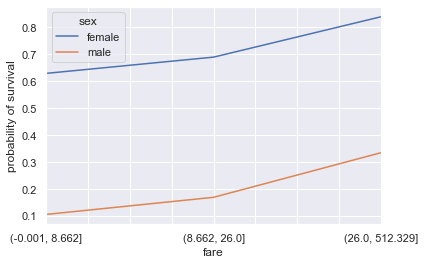

In [55]:
sns.set()
titanic.pivot_table('survived', index=fare_range,columns='sex', aggfunc='mean').plot()
plt.ylabel('probability of survival')

The pd.cut() and pd.qcut() are two important functions when it comes to dealing with pivot tables. The pd.cut() method bins values into discrete intervals.if you need to segment and sort data values into bins, this function will be useful for going from a continuous variable to a categorical variable. It can return a 'Series' object or an 'ndarray' object. THe pd.qcut() method discretizes variable into equal-sized buckets based on rank or based on sample quantiles. For example 1000 values for 10 quantiles would produce a Categorical object indicating quantile membership for each data point. Here are some additional example:

In [35]:
s1 = pd.Series(np.array([2, 4, 6, 8, 10]),index=['a', 'b', 'c', 'd', 'e']) # passing a 'Series' as an input returns a 'Series' with categorical dtype
print(s1)
print('\n')
s2=pd.qcut(range(5), 4)
print(s2)
pd.qcut(range(5), 3, labels=["good", "medium", "bad"])

a     2
b     4
c     6
d     8
e    10
dtype: int32


[(-0.001, 1.0], (-0.001, 1.0], (1.0, 2.0], (2.0, 3.0], (3.0, 4.0]]
Categories (4, interval[float64]): [(-0.001, 1.0] < (1.0, 2.0] < (2.0, 3.0] < (3.0, 4.0]]


[good, good, medium, bad, bad]
Categories (3, object): [good < medium < bad]

There are additional options for pivto tables. For example, the 'fill_value=' argument and 'dropna=' argument are straightforward, and the 'aggfunc=' keyword controls what type of aggregation is applied (e.g. 'sum', 'count', 'mean' etc.). The 'margin=' keyword is useful when we want to compute totals along each grouping: 

In [40]:
titanic.pivot_table(values='survived', index='sex', columns='class',margins=True, margins_name='Overall')

class,First,Second,Third,Overall
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
Overall,0.629630,0.472826,0.242363,0.383838


References:
   - https://jakevdp.github.io/PythonDataScienceHandbook/03.09-pivot-tables.html
   - https://jakevdp.github.io/PythonDataScienceHandbook/03.08-aggregation-and-grouping.html
   - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.groupby.html
   - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
   - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.qcut.html